In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d  # 导入函数

from sklearn.metrics import pairwise_distances  # 导入函数

# 输出一个 N x k 的矩阵，其中每个观测值在 X 中有 k 个最近邻
def nearest_neighbors(X, k):
    # 这里我们使用 k+1，因为 Xi 会与自身具有最短的距离
    knn_matrix = np.zeros((len(X), k))  # 创建一个全零矩阵
    # 计算两两之间的距离
    dist_matrix = pairwise_distances(X)  # 计算特征矩阵 X 的两两距离
    # 对于每一行找出 k 个最近邻的索引
    for i in range(len(X)):
        knn_matrix[i] = dist_matrix[i,:].argsort()[1:k+1]  # 对距离排序并取最近的 k 个邻居的索引
    return knn_matrix  # 返回最近邻矩阵
sns.set()  # 设置 seaborn 默认格式

def compute_adaptive_neighbors(Data):
    n = Data.shape[1]  # 样本点的数量
    print(n)
    distances = np.sqrt(np.sum((Data.T[:, :, None] - Data.T[:, :, None].T) ** 2, axis=1)) 
    sorted_distances = np.sort(distances, axis=1)  # 对距离矩阵的每一行进行排序
    np.savetxt('sorted_distances.csv', sorted_distances, delimiter=',')
    adaptive_neighbors = np.zeros((n, 1))
    # 对每行距离进行插值和求导
    for i in range(n):
        # 对距离进行插值，生成连续的函数
        f = interp1d(np.arange(n), sorted_distances[i], kind='linear')
        # 求导
        df = np.gradient(f(np.arange(n)))  # 计算函数的导数
        # 寻找导数为1的位置
        idx = np.where(df <= 1)[0][0]
        # 将索引保存为每个数据点的邻居数量
        adaptive_neighbors[i] = idx
    return adaptive_neighbors, sorted_distances, distances

# 根据adaptive_neighbors中每一行的邻居数量和sorted_distances对每个数据点构建epsilon graph
def adaptive_epsilon_graph(Data, method, k):
    adaptive_neighbors, sorted_distances, distances = compute_adaptive_neighbors(Data)
    n = Data.shape[1]  
    adaptive_epsilon_adjacency_matrix = np.zeros((n, n)) 
    if method == "Adaptive epsilon": # 计算自适应epsilon graph，不管k值
        for i in range(n):
            indices = np.argsort(sorted_distances[i])[:int(adaptive_neighbors[i])]
            adaptive_epsilon_adjacency_matrix[i, indices] = 1
            adaptive_epsilon_adjacency_matrix[indices, i] = 1
        return adaptive_epsilon_adjacency_matrix, distances
    elif method == "KNN + Adaptive epsilon": # 以k值为邻居数的阈值，小于k值的邻居数使用adaptive epsilon graph，大于k值的邻居数使用knn graph
        for i in range(n):
            if adaptive_neighbors[i] <= k:
                indices = np.argsort(sorted_distances[i])[:int(adaptive_neighbors[i])]
                adaptive_epsilon_adjacency_matrix[i, indices] = 1
                adaptive_epsilon_adjacency_matrix[indices, i] = 1
            else:
                indices = np.argsort(distances[i])[:k]
                adaptive_epsilon_adjacency_matrix[i, indices] = 1
                adaptive_epsilon_adjacency_matrix[indices, i] = 1
        return adaptive_epsilon_adjacency_matrix, distances


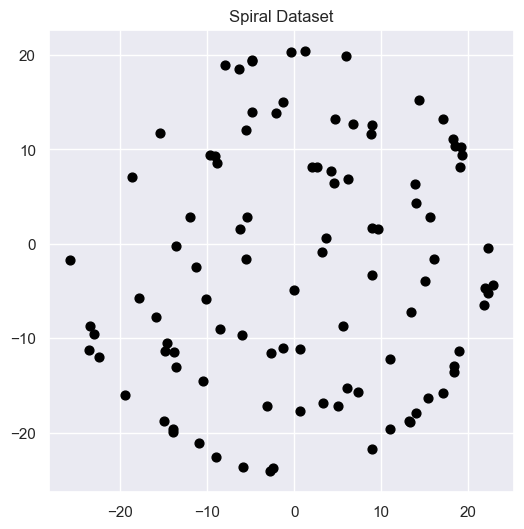

In [67]:
'''
# 生成螺旋数据集
n = 100  # 数据集大小
u = np.sqrt(np.random.rand(n,1)) * 1440 * (2*np.pi)/360  # 生成随机值 u
x = -np.cos(u)*u + np.random.randn(n,1)*0.5  # 计算 x 坐标
y = np.sin(u)*u + np.random.randn(n,1)*0.5  # 计算 y 坐标
X = np.hstack((x,y))  # 合并 x 和 y 到 X
# 将数据集保存为文本文件（CSV格式）
np.savetxt('spiral_dataset.csv', X, delimiter=',')
'''

# 加载保存的数据集
X = np.loadtxt('D:/Manifold-Learning/Locally linear embedding/spiral_dataset.csv', delimiter=',')
# 将第一列数据分配给 x，第二列数据分配给 y
x = X[:, 0]
y = X[:, 1]

# 绘制散点图
plt.figure(figsize=(6,6))  # 设置画布大小为 6x6
plt.scatter(x, y, c='black', s=40)  # 绘制散点图，用黑色表示数据点，设置点的大小为 40
plt.title('Spiral Dataset')  # 设置图标题为 'Spiral Dataset'
plt.show();  # 展示图形

100


C:\Users\Tony-Huang\AppData\Local\Temp\ipykernel_31272\2174948798.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  indices = np.argsort(sorted_distances[i])[:int(adaptive_neighbors[i])]


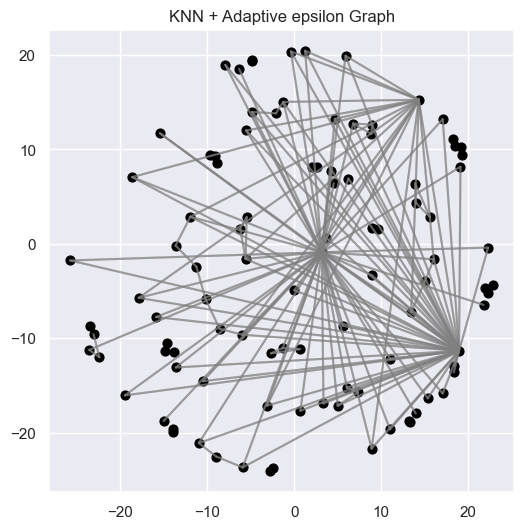

In [68]:
# 遍历每个数据点并绘制到最近邻的连线
plt.figure(figsize=(6,6))  # 设置画布大小为 6x6
plt.scatter(X[:,0], X[:,1], alpha=1, c='black', s=40)  # 绘制散点图，alpha 为不透明度，用黑色表示数据点，点的大小为 40
k = 3  # 设置最近邻的数量
adaptive_graph = adaptive_epsilon_graph(X.T, "KNN + Adaptive epsilon", k)  # 找到每个数据点的最近邻索引，返回整数数组

# 循环遍历每个数据点,绘制连接当前点与其最近邻之间的灰色线段
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        if adaptive_graph[0][i, j] == 1:
            plt.plot([X[i, 0], X[j, 0]], [X[i, 1], X[j, 1]], color='gray', alpha=0.5)  # 绘制灰色线段
plt.title('KNN + Adaptive epsilon Graph')  # 设置图标题为 'KNN + Adaptive epsilon Graph'
plt.show();  # 展示图形


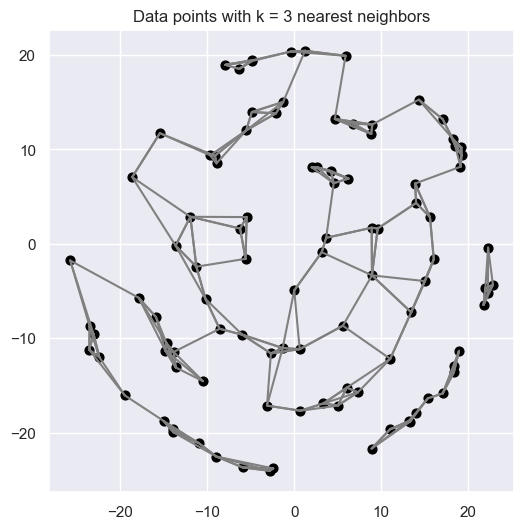

In [69]:
# 遍历每个数据点并绘制到最近邻的连线
plt.figure(figsize=(6,6))  # 设置画布大小为 6x6
plt.scatter(X[:,0], X[:,1], alpha=1, c='black', s=40)  # 绘制散点图，alpha 为不透明度，用黑色表示数据点，点的大小为 40
k = 3  # 设置最近邻的数量为 3
neighbors = nearest_neighbors(X, k).astype('int')  # 找到每个数据点的最近邻索引，返回整数数组

# 循环遍历每个数据点
for i in range(len(X)):
    knn = neighbors[i]  # 获取第 i 个数据点的最近邻索引
    # 循环遍历每个最近邻
    for j in range(k):
        # 绘制连接当前点与其最近邻之间的灰色线段
        plt.plot(X[[i, knn[j]], 0], X[[i, knn[j]], 1], c='gray')  # 绘制当前点与最近邻之间的连线，颜色为灰色

plt.title('Data points with k = '+ str(k) + ' nearest neighbors')  # 设置图标题
plt.show();  # 展示图形

#当k=1时，每个数据点只有一个最近邻，这对于邻域关系的捕捉是不够的。我们可以通过增加k的值来改善这种情况。

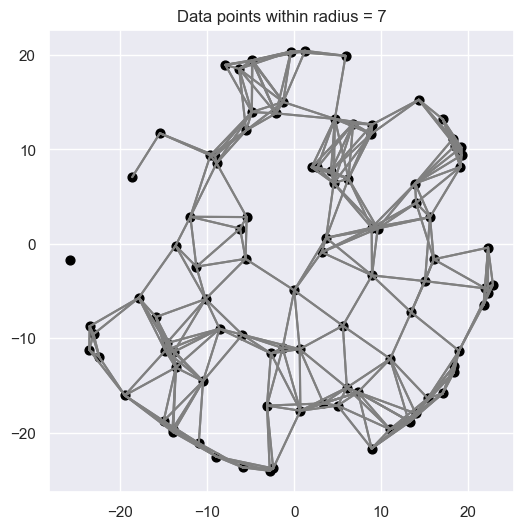

In [70]:
def epsilon_graph(X, radius):
    epsilon_matrix = np.zeros((len(X), len(X)))  # 创建一个全零矩阵
    # 计算两两之间的距离
    dist_matrix = pairwise_distances(X)  # 计算特征矩阵 X 的两两距离
    # 对于每一行找出半径在radius内的邻居
    for i in range(len(X)):
        epsilon_matrix[i] = dist_matrix[i] < radius
    return epsilon_matrix  # 返回邻接矩阵


# 遍历每个数据点并绘制到最近邻的连线
plt.figure(figsize=(6,6))  # 设置画布大小为 6x6
plt.scatter(X[:,0], X[:,1], alpha=1, c='black', s=40)  # 绘制散点图，alpha 为不透明度，用黑色表示数据点，点的大小为 40
radius = 7  # 设置半径
neighbors = epsilon_graph(X, radius)  # 获取半径为 radius 的邻接矩阵

# 循环遍历每个数据点
for i in range(len(X)):
    # 循环遍历每个最近邻
    for j in range(len(X)):
        if neighbors[i][j] == 1:
            # 绘制连接当前点与其最近邻之间的灰色线段
            plt.plot(X[[i, j], 0], X[[i, j], 1], c='gray')  # 绘制当前点与最近邻之间的连线，颜色为灰色
plt.title('Data points within radius = ' + str(radius) );  # 设置图标题为 'Data within radius = k'